## Import Packages

In [10]:
def helper_display_img(image, title):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

In [12]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

from skimage.feature import hog
from skimage import data, color, exposure

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import requests

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [3]:
url = "https://tripjive.com/wp-content/uploads/2023/12/The-most-charming-German-villages-near-Berlin.jpg"

(768, 1344, 3)
after resize: (224, 224, 3)


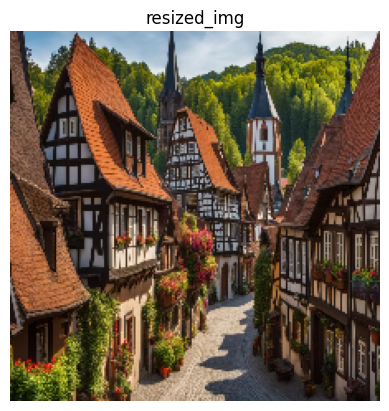

In [148]:
# Get the image from the URL
response = requests.get(url)
img = Image.open(BytesIO(response.content))
print(np.array(img).shape)

# Resize
resized_img = cv2.resize(np.array(img), (224, 224), interpolation=cv2.INTER_LINEAR)
print("after resize: {}".format(resized_img.shape))

# Display
helper_display_img(resized_img, "resized_img")

# Object Detection

## Deteksi Objek Menggunakan Histogram of Oriented Gradients (HoG)

Histogram of Oriented Gradients (HoG) adalah metode ekstraksi fitur yang berguna untuk deteksi objek berdasarkan arah gradien.



(25088,)
(224, 224)


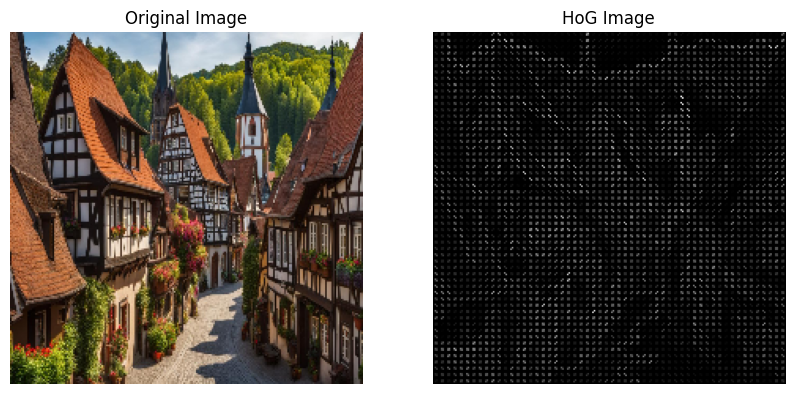

In [42]:
# Ekstraksi fitur HoG
features, hog_image = hog(resized_img, orientations=8, pixels_per_cell=(4,4),
                          cells_per_block=(1,1),
                          visualize=True,
                          channel_axis=-1)
print(features.shape)
print(hog_image.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
helper_display_img(resized_img, "Original Image")

plt.subplot(1, 2, 2)
helper_display_img(hog_image, "HoG Image")

plt.show()

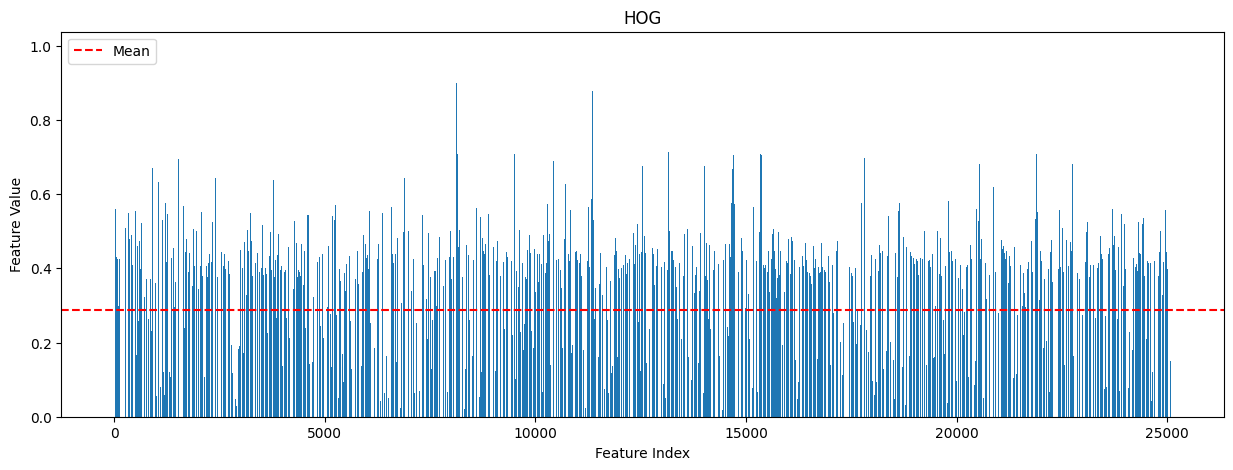

In [49]:
vals = range(len(features))

# Create a bar plot
plt.figure(figsize=(15,5))
plt.bar(vals, features)
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')

# Add horizontal line for the mean
mean_fd = np.mean(features)
plt.axhline(y=mean_fd, color='r', linestyle='--', label='Mean')
plt.legend()  # Display legend to show the mean line


plt.title('HOG')
plt.show()

## Deteksi Objek Berbasis Fitur dengan OpenCV

Deteksi berbasis fitur menggunakan metode seperti SIFT (Scale-Invariant Feature Transform) untuk menemukan titik-titik penting dalam citra.



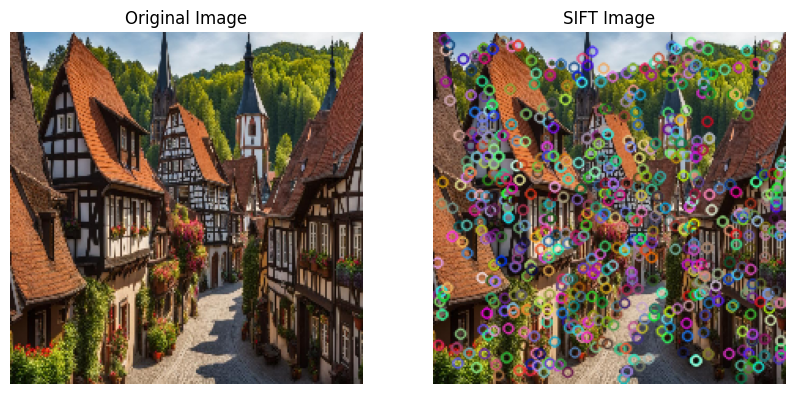

In [50]:
gray_image = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

# Inisialisasi detektor SIFT
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray_image, None)

# Visualisasi hasil
output_image = cv2.drawKeypoints(resized_img, keypoints, None)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
helper_display_img(resized_img, "Original Image")

plt.subplot(1, 2, 2)
helper_display_img(output_image, "SIFT Image")
plt.show()

## Deteksi Objek Menggunakan CNN (Convolutional Neural Network)


CNN adalah metode populer untuk deteksi objek. Kita akan menggunakan model pre-trained, misalnya MobileNetV2, yang sudah dilatih pada dataset ImageNet.



In [53]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import tensorflow as tf

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1. tile_roof: 37.45%
2. palace: 5.96%
3. prison: 2.78%


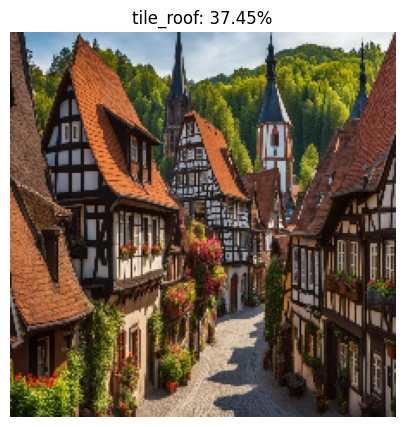

In [55]:
# Load model pre-trained MobileNetV2
model = MobileNetV2(weights="imagenet")

# Pre-processing citra
img_array = tf.keras.utils.img_to_array(resized_img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Prediksi objek dalam citra
predictions = model.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=3)[0]

# Menampilkan hasil prediksi
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}. {label}: {score * 100:.2f}%")

# Display
plt.figure(figsize=(10, 5))
title = f"{decoded_predictions[0][1]}: {decoded_predictions[0][2] * 100:.2f}%"
helper_display_img(resized_img, title)

# Segmentation

## Segmentasi Citra Menggunakan Thresholding

Thresholding adalah metode segmentasi dasar yang membagi citra berdasarkan intensitas piksel.



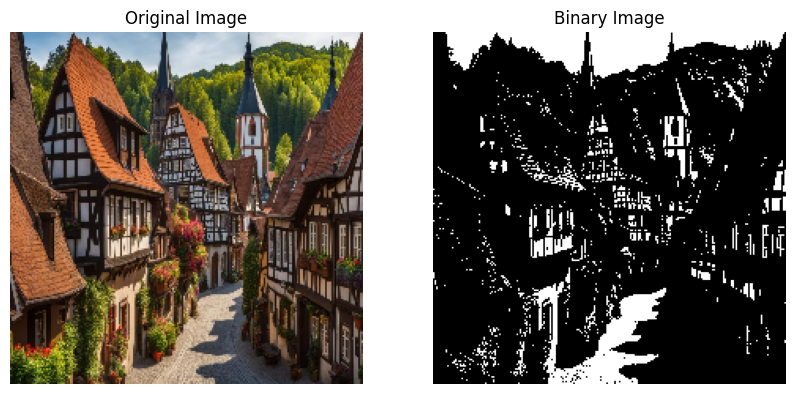

In [57]:
# Apply thresholding
gray_image = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Visualisasi hasil
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
helper_display_img(resized_img, "Original Image")

plt.subplot(1, 2, 2)
helper_display_img(binary_image, "Binary Image")
plt.show()

## Segmentasi Citra Menggunakan K-Means


K-Means melakukan segmentasi berdasarkan pengelompokan warna atau intensitas piksel.

(50176, 1)


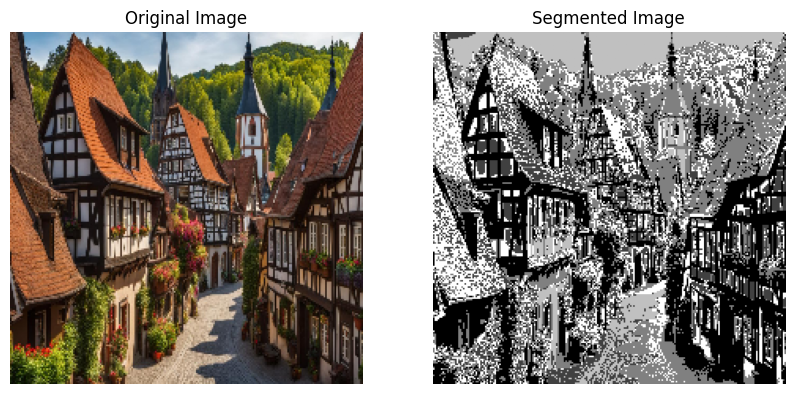

In [96]:
from sklearn.cluster import KMeans

gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

# Reshape the image to a 2D array of pixels
w, h = gray.shape
image_array = gray.reshape(-1,1)
print(image_array.shape)

# Number of clusters (colors)
n_colors = 5

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array)

# Get the cluster labels for all pixels
labels = kmeans.predict(image_array)

# Reshape the labels back to the original image shape
segmented_image = labels.reshape(w, h)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
helper_display_img(resized_img, "Original Image")

plt.subplot(1, 2, 2)
helper_display_img(segmented_image, "Segmented Image")
plt.show()

## Segmentasi Citra Menggunakan Watershed


Metode Watershed bekerja dengan menentukan area tertentu sebagai objek atau latar belakang berdasarkan gradien.



(2304, 3072, 3)
after resize: (224, 224, 3)


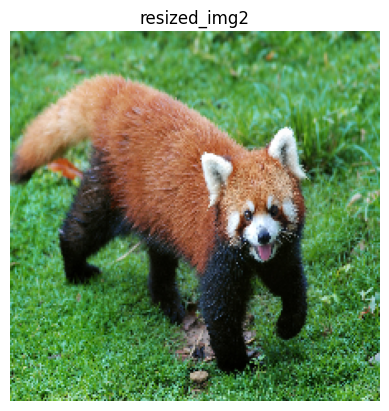

In [147]:
url2 = "https://i.natgeofe.com/k/63b1a8a7-0081-493e-8b53-81d01261ab5d/red-panda-full-body_4x3.jpg"

# Get the image from the URL
response = requests.get(url2)
img2 = Image.open(BytesIO(response.content))
print(np.array(img2).shape)

# Resize
resized_img2 = cv2.resize(np.array(img2), (224, 224), interpolation=cv2.INTER_LINEAR)
print("after resize: {}".format(resized_img2.shape))

# Display
helper_display_img(resized_img2, "resized_img2")

(224, 224)


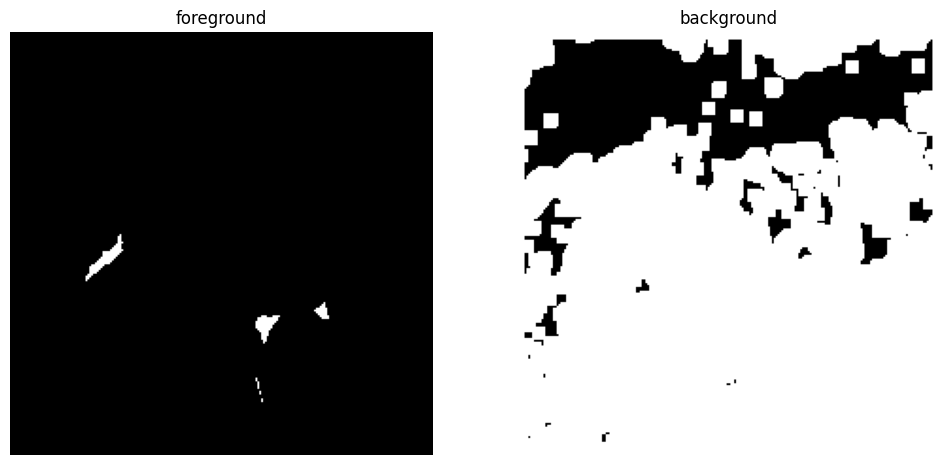

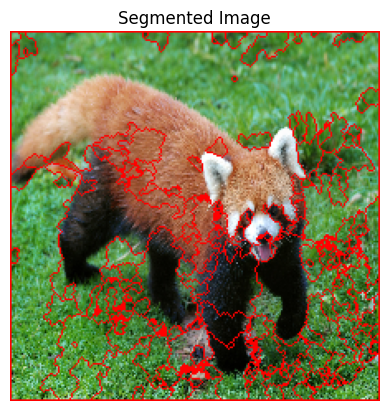

In [146]:
gray = cv2.cvtColor(resized_img2, cv2.COLOR_BGR2GRAY)
print(gray.shape)

_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Area latar depan
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
_, foreground = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

background = cv2.dilate(binary, None, iterations=3)

# Watershed
unknown = cv2.subtract(background.astype(np.uint8), foreground.astype(np.uint8))
markers = cv2.connectedComponents(foreground.astype(np.uint8))[1]
markers += 1
markers[unknown == 255] = 0
cv2.watershed(resized_img2, markers)

# display
plt.figure(figsize=(12,10))
plt.subplot(1, 2, 1)
helper_display_img(foreground, "foreground")

plt.subplot(1, 2, 2)
helper_display_img(background, "background")
plt.show()

resized_img2[markers == -1] = [255 ,0, 0]
helper_display_img(resized_img2, "Segmented Image")
plt.show()
